In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms, datasets
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to [-1, 1]
])

# Load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Increase the number of output channels in the convolutional layers to 30
        self.conv1 = nn.Conv2d(1, 30, 3, 1, 1)
        self.conv2 = nn.Conv2d(30, 30, 3, 1, 1)
        self.conv3 = nn.Conv2d(30, 30, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        # Update the size of the flattened grid for the first fully connected layer
        # Assuming the input images are 28x28 pixels, after 3 pooling layers, the size becomes 3x3
        self.fc1_input_size = 30 * 3 * 3  # Updated to reflect the increased number of output channels
        self.fc1 = nn.Linear(self.fc1_input_size, 30)  # Increase the output size of fc1 to 30
        self.fc2 = nn.Linear(30, 10)  # Output layer remains the same as there are 10 classes
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1_input_size)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Reinitialize the model, loss function, and optimizer with the updated architecture
model = FashionCNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Function to train the model
def train_model(model, train_loader, optimizer, loss_function, epochs=8):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()  # Zero the gradients
            output = model(data)  # Forward pass
            loss = loss_function(output, target)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total += target.size(0)  # Total number of labels
            correct += (predicted == target).sum().item()  # Correct predictions

        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Train the model
train_model(model, train_loader, optimizer, loss_function, epochs=10)


# Modify the FashionCNN model to use a softmax output for MSE Loss
class FashionCNN_MSE(nn.Module):
    def __init__(self):
        super(FashionCNN_MSE, self).__init__()
        # Convolutional layers remain unchanged
        self.conv1 = nn.Conv2d(1, 30, 3, 1, 1)
        self.conv2 = nn.Conv2d(30, 30, 3, 1, 1)
        self.conv3 = nn.Conv2d(30, 30, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1_input_size = 30 * 3 * 3
        self.fc1 = nn.Linear(self.fc1_input_size, 30)
        self.fc2 = nn.Linear(30, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1_input_size)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # Apply softmax to the output layer for MSE Loss
        x = F.softmax(x, dim=1)
        return x

# Use MSE Loss
loss_function_mse = nn.MSELoss()

# Instantiate the modified model
model_mse = FashionCNN_MSE()

# Optimizer remains the same
optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.001)

# Note: When using MSE Loss for classification, the target labels should be one-hot encoded.
# You may need to adjust the training loop to accommodate this change in label format.


import torch

def one_hot_encode(labels, num_classes=10):
    # Convert to one-hot encoded vectors
    return torch.eye(num_classes)[labels]

def train_model_mse(model, train_loader, optimizer, loss_function, epochs=10, num_classes=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            # One-hot encode the targets
            targets_one_hot = one_hot_encode(targets, num_classes).to(data.device)
            
            optimizer.zero_grad()  # Zero the gradients
            output = model(data)  # Forward pass
            loss = loss_function(output, targets_one_hot)  # Compute the loss with one-hot targets
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total += targets.size(0)  # Total number of labels
            correct_predictions += (predicted == targets).sum().item()  # Correct predictions

        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = 100 * correct_predictions / total
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Instantiate the model, optimizer, and use MSE Loss
model_mse = FashionCNN_MSE()
optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.001)
loss_function_mse = nn.MSELoss()

# Run the training loop
train_model_mse(model_mse, train_loader, optimizer_mse, loss_function_mse, epochs=10)


Epoch 1, Loss: 0.0167, Accuracy: 60.05%
Epoch 2, Loss: 0.0115, Accuracy: 72.78%
Epoch 3, Loss: 0.0103, Accuracy: 75.65%
Epoch 4, Loss: 0.0097, Accuracy: 77.43%
Epoch 5, Loss: 0.0092, Accuracy: 78.37%
Epoch 6, Loss: 0.0088, Accuracy: 79.68%
Epoch 7, Loss: 0.0085, Accuracy: 80.24%
Epoch 8, Loss: 0.0082, Accuracy: 80.88%
Epoch 9, Loss: 0.0081, Accuracy: 81.37%
Epoch 10, Loss: 0.0079, Accuracy: 81.94%
Epoch 1, Loss: 0.0008, Accuracy: 61.95%
Epoch 2, Loss: 0.0006, Accuracy: 73.79%
Epoch 3, Loss: 0.0005, Accuracy: 76.67%
Epoch 4, Loss: 0.0005, Accuracy: 78.63%
Epoch 5, Loss: 0.0004, Accuracy: 79.82%
Epoch 6, Loss: 0.0004, Accuracy: 80.63%
Epoch 7, Loss: 0.0004, Accuracy: 81.66%
Epoch 8, Loss: 0.0004, Accuracy: 82.18%
Epoch 9, Loss: 0.0004, Accuracy: 82.91%
Epoch 10, Loss: 0.0004, Accuracy: 83.02%


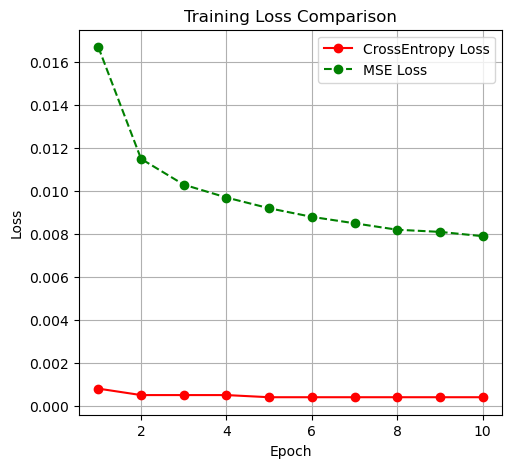

In [5]:
import matplotlib.pyplot as plt

# Example data for CrossEntropy Loss
loss_values_ce = [0.0008, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004]
accuracy_values_ce = [62.56, 74.40, 76.92, 78.75, 79.91, 80.88, 81.49, 81.88, 82.64, 82.96]

# Example data for MSE Loss
loss_values_mse = [0.0167, 0.0115, 0.0103, 0.0097, 0.0092, 0.0088, 0.0085, 0.0082, 0.0081, 0.0079]
accuracy_values_mse = [60.05, 72.78, 75.65, 77.43, 78.37, 79.68, 80.24, 80.88, 81.37, 81.94]

epochs = range(1, 11)

plt.figure(figsize=(12, 5))

# Plotting Training Loss for both loss functions
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values_ce, 'r-o', label='CrossEntropy Loss')
plt.plot(epochs, loss_values_mse, 'g--o', label='MSE Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()




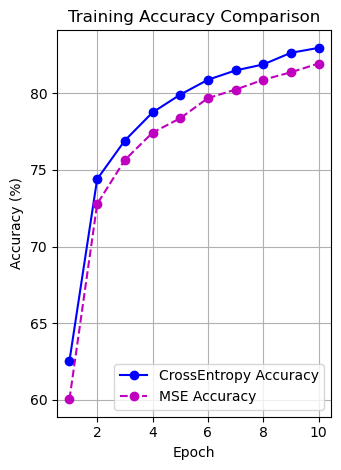

In [6]:
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values_ce, 'b-o', label='CrossEntropy Accuracy')
plt.plot(epochs, accuracy_values_mse, 'm--o', label='MSE Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

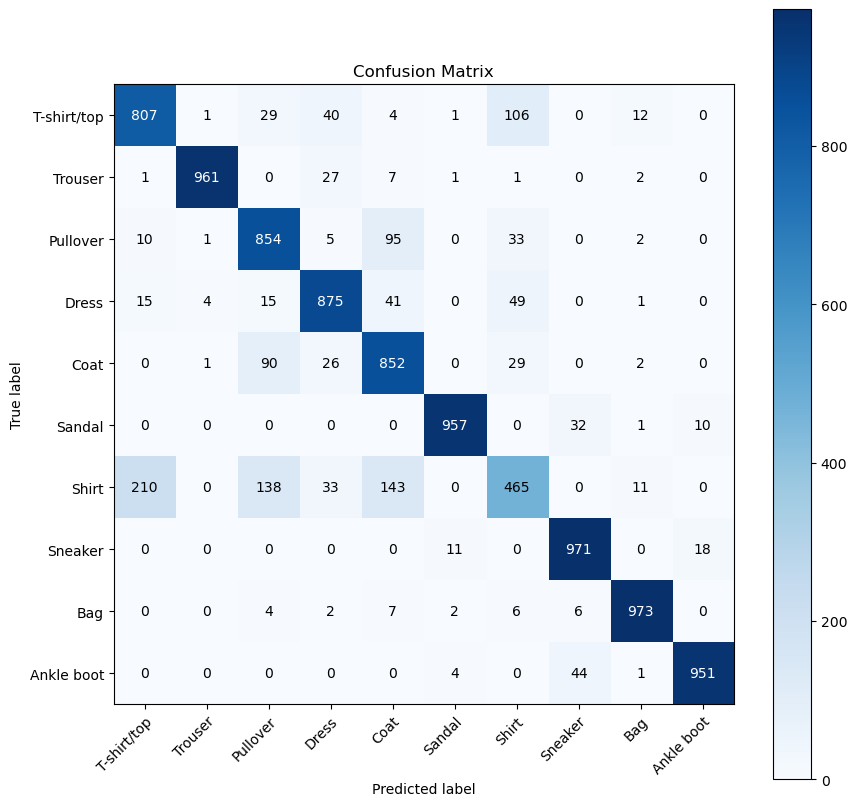

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

conf_mat = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()

plot_confusion_matrix(conf_mat, datasets.FashionMNIST.classes)

def visualize_misclassified_examples(X_test, y_true, y_pred, target_class_idx, class_names):
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == target_class_idx and pred != target_class_idx]
    num_examples = min(len(misclassified_indices), 25)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_indices[:num_examples]):
        plt.subplot(5, 5, i + 1)
        img = X_test[idx].squeeze()
        plt.imshow(img, cmap='gray')
        plt.title(f'Pred: {class_names[y_pred[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [1]:
!pip list


Package                   Version
------------------------- ------------
anyio                     4.2.0
appnope                   0.1.3
archspec                  0.2.3
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 2.0.5
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.11.0
beautifulsoup4            4.12.2
bleach                    4.1.0
boltons                   23.0.0
Brotli                    1.0.9
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        2.0.4
comm                      0.2.1
conda                     24.3.0
conda-content-trust       0.2.0
conda-libmamba-solver     23.12.0
conda-package-handling    2.2.0
conda_package_streaming   0.9.0
cryptography              41.0.7
debugpy                   1.6.7
decorator                 5.1.1
defusedxml                0.7.1
distro                    1.8.0
executing                 0.8.3
fastjsonschema   